<a href="https://colab.research.google.com/github/eaglepython/Healthcare-Analytics-Portfolio/blob/main/Real_Time_Warranty_Claim_Anomaly_Detection_System_gpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Real-Time Warranty Claim Anomaly Detection

#### Overview

This project simulates a real-world data science workflow used in automotive manufacturing and warranty operations. The goal is to detect unusual or fraudulent vehicle warranty claims using machine learning. We treat anomaly detection as a semi-supervised problem, where most data is normal, and rare events (fraud or unexpected failure) need to be flagged.

### Project Objective
####Business Problem

Large automotive companies process thousands of warranty claims daily. Some claims:

  Indicate early part failure (requiring recalls).

  Reflect abnormal usage patterns (e.g., very high mileage for a new car).

   May be fraudulent (fake repair invoices).

Flagging such anomalies early can:

   Save millions in warranty costs.

   Protect customers.

   Improve manufacturing quality feedback loops.

####Dataset Description

We used two datasets:

  vehicle_claims.csv – Raw historical vehicle warranty claims

  vehicle_claims_labeled.csv – Same data but with labels like "normal", "early_failure", "fraud" (optional for evaluation)

In [13]:
# ==============================
# Step 1: Load and Preview Data
# ==============================
import pandas as pd

# Load dataset
import pandas as pd

# Load the dataset
df1 = pd.read_csv("/content/vehicle_claims.csv")
df2 = pd.read_csv("/content/vehicle_claims_labeled.csv")

# Display the first few rows of the dataset
df1.head()


,Maker,Genmodel,Genmodel_ID,Adv_year,Adv_month,Color,Reg_year,Bodytype,Runned_Miles,Engin_size,...,Seat_num,Door_num,issue,issue_id,Adv_day,breakdown_date,repair_complexity,repair_cost,repair_hours,repair_date
0,Bentley,Arnage,10_1,2018,4,Silver,2000.0,Saloon,60000,6.8L,...,5.0,4.0,Electrical Issue,4,12,2018-04-12,3,184.5000,6.0,2018-04-13
1,Bentley,Arnage,10_1,2018,6,Grey,2002.0,Saloon,44000,6.8L,...,5.0,4.0,Brake Pads Worn,0,10,2018-06-10,3,134.3750,6.0,2018-06-11
2,Bentley,Arnage,10_1,2017,11,Blue,2002.0,Saloon,55000,6.8L,...,5.0,4.0,Flat Tyres,0,2,2017-11-02,3,68.9997,3.0,2017-11-02
3,Bentley,Arnage,10_1,2018,4,Green,2003.0,Saloon,14000,6.8L,...,5.0,4.0,Gear Box Issue,0,27,2018-04-27,3,469.4800,6.0,2018-04-28
4,Bentley,Arnage,10_1,2017,11,Grey,2003.0,Saloon,61652,6.8L,...,5.0,4.0,Electrical Issue,4,23,2017-11-23,3,199.6650,6.0,2017-11-24


In [24]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268255 entries, 0 to 268254
Data columns (total 25 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Maker              268255 non-null  object 
 1    Genmodel          268255 non-null  object 
 2    Genmodel_ID       268255 non-null  object 
 3   Adv_year           268255 non-null  int64  
 4   Adv_month          268255 non-null  int64  
 5   Color              268255 non-null  object 
 6   Reg_year           268255 non-null  float64
 7   Bodytype           268255 non-null  object 
 8   Runned_Miles       268255 non-null  int64  
 9   Engin_size         268255 non-null  object 
 10  Gearbox            268255 non-null  object 
 11  Fuel_type          268255 non-null  object 
 12  Price              268255 non-null  float64
 13  Seat_num           268255 non-null  float64
 14  Door_num           268255 non-null  float64
 15  issue              268255 non-null  object 
 16  is

In [15]:
# Interpretation: Review the data types, check for null values, and look at value distributions.
# Summarize what each column means and any immediate issues (e.g., mixed types, dirty formats).

# Basic data structure and types
df1.info()
df1.describe(include='all')  # Includes both numeric and categorical


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268255 entries, 0 to 268254
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Maker              268255 non-null  object 
 1    Genmodel          268255 non-null  object 
 2    Genmodel_ID       268255 non-null  object 
 3   Adv_year           268255 non-null  int64  
 4   Adv_month          268255 non-null  int64  
 5   Color              268255 non-null  object 
 6   Reg_year           268255 non-null  float64
 7   Bodytype           268255 non-null  object 
 8   Runned_Miles       268255 non-null  object 
 9   Engin_size         268255 non-null  object 
 10  Gearbox            268255 non-null  object 
 11  Fuel_type          268255 non-null  object 
 12  Price              268255 non-null  float64
 13  Seat_num           268255 non-null  float64
 14  Door_num           268255 non-null  float64
 15  issue              268255 non-null  object 
 16  is

,Maker,Genmodel,Genmodel_ID,Adv_year,Adv_month,Color,Reg_year,Bodytype,Runned_Miles,Engin_size,...,Seat_num,Door_num,issue,issue_id,Adv_day,breakdown_date,repair_complexity,repair_cost,repair_hours,repair_date
count,268255,268255,268255,268255.000000,268255.000000,268255,268255.000000,268255,268255,268255,...,268255.000000,268255.000000,268255,268255.000000,268255.000000,268255,268255.000000,268255.000000,268255.000000,268255
unique,88,896,881,NaN,NaN,23,NaN,19,73451,75,...,NaN,NaN,15,NaN,NaN,1458,NaN,NaN,NaN,2776
top,Ford,Corsa,94_9,NaN,NaN,Black,NaN,Hatchback,10,2.0L,...,NaN,NaN,Transmission Issue,NaN,NaN,2018-05-21,NaN,NaN,NaN,2018-05-21
freq,26937,5569,5569,NaN,NaN,48751,NaN,103768,2616,59289,...,NaN,NaN,17988,NaN,NaN,2228,NaN,NaN,NaN,2171
mean,NaN,NaN,NaN,2018.127778,5.626143,NaN,2012.734454,NaN,NaN,NaN,...,5.147472,4.297396,NaN,0.500617,14.530342,NaN,1.361496,442.241517,62.298814,NaN
std,NaN,NaN,NaN,0.747476,2.091577,NaN,6.774572,NaN,NaN,NaN,...,1.839659,1.149057,NaN,1.136500,8.066918,NaN,0.725593,1995.239405,798.507803,NaN
min,NaN,NaN,NaN,2012.000000,1.000000,NaN,1900.000000,NaN,NaN,NaN,...,1.000000,0.000000,NaN,0.000000,1.000000,NaN,1.000000,-2998.000000,-29.000000,NaN
25%,NaN,NaN,NaN,2018.000000,4.000000,NaN,2010.000000,NaN,NaN,NaN,...,5.000000,4.000000,NaN,0.000000,8.000000,NaN,1.000000,40.700000,1.000000,NaN
50%,NaN,NaN,NaN,2018.000000,5.000000,NaN,2014.000000,NaN,NaN,NaN,...,5.000000,5.000000,NaN,0.000000,15.000000,NaN,1.000000,120.500000,2.000000,NaN
75%,NaN,NaN,NaN,2018.000000,7.000000,NaN,2016.000000,NaN,NaN,NaN,...,5.000000,5.000000,NaN,0.000000,22.000000,NaN,1.000000,330.787978,6.000000,NaN


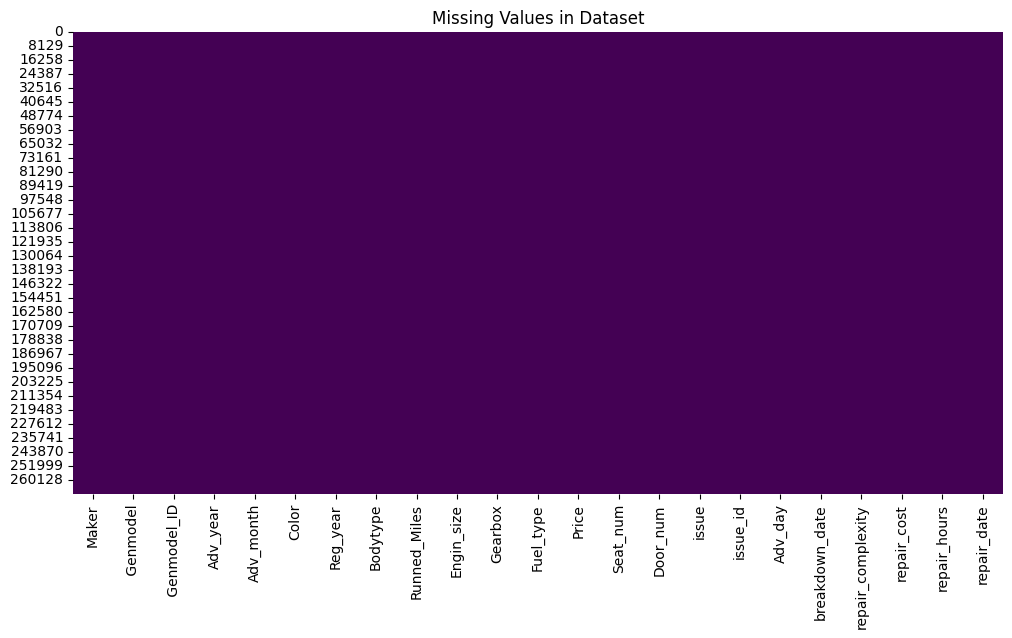

,0


In [16]:
# Interpretation: Identify which columns have missing values and decide whether to impute, drop, or leave them based on their importance.

import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap of missing values
plt.figure(figsize=(12,6))
sns.heatmap(df1.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values in Dataset")
plt.show()

# Percentage of missing values
missing_percent = df1.isnull().mean() * 100
missing_percent[missing_percent > 0].sort_values(ascending=False)


In [18]:
# Interpretation: Validate conversions, and review new repair_delay_days column—does it make sense? Any negative values or outliers?

# Convert mileage to numeric
df1['Runned_Miles'] = df1['Runned_Miles'].str.replace(',', '').str.replace(' mile', '').astype(float)

# Convert Engin_size to float
df1['Engin_size'] = df1['Engin_size'].str.replace('L', '').astype(float)

# Convert dates to datetime format
df1['breakdown_date'] = pd.to_datetime(df1['breakdown_date'])
df1['repair_date'] = pd.to_datetime(df1['repair_date'])

# Extract repair delay in days
df1['repair_delay_days'] = (df1['repair_date'] - df1['breakdown_date']).dt.days

**Feature engineering**

This line of code creates a new column called repair_delay_days. This column is calculated by subtracting the breakdown_date from the repair_date. Since both columns are now in datetime format, the subtraction results in a Timedelta object (representing the time difference). We then access the .dt.days attribute of this Timedelta object to extract the difference in days, creating a useful numerical feature representing how long it took to repair the vehicle after the breakdown.

In [19]:
#Interpretation: Document what encoding was done and why. How many new columns were added?

# One-hot encode selected columns
df_encoded = pd.get_dummies(df1, columns=['Maker', 'Bodytype', 'Fuel_type', 'issue'], drop_first=True)

# Fill any remaining missing values
df_encoded.fillna(df_encoded.median(numeric_only=True), inplace=True)


 these two lines transform the data by converting categorical features into a numerical format suitable for machine learning and fill in any remaining missing values with the median of their respective columns. This is a common data preprocessing step before training models.

###Stage 3: Exploratory Data Analysis (EDA)
🔹 Step 3.1: Cost vs Repair Complexity

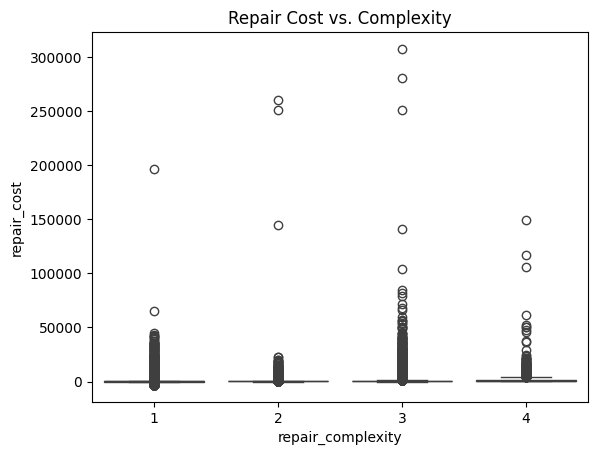

In [20]:
# Interpretation: Do more complex repairs cost more? Any outliers?

sns.boxplot(data=df1, x='repair_complexity', y='repair_cost')
plt.title("Repair Cost vs. Complexity")
plt.show()


this code generates a box plot to visualize the distribution of repair_cost across different levels of repair_complexity in the df1 dataset. This helps in understanding how the cost of repairs varies depending on how complex the repair is.

🔹 Step 3.2: Mileage vs Repair Cost

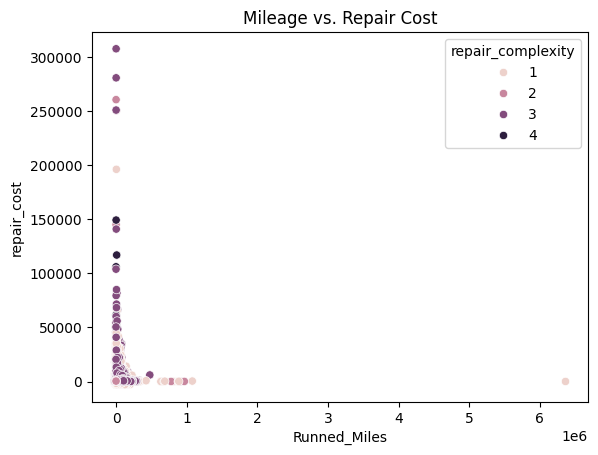

In [21]:
# Interpretation: Are older or more driven vehicles associated with higher costs?

sns.scatterplot(data=df1, x='Runned_Miles', y='repair_cost', hue='repair_complexity')
plt.title("Mileage vs. Repair Cost")
plt.show()


In essence, this code generates a visual representation to help understand if vehicles with higher mileage tend to have higher repair costs, and it also adds a dimension by showing how the complexity of the repair influences this relationship.

🔹 Step 3.3: Anomaly Signals

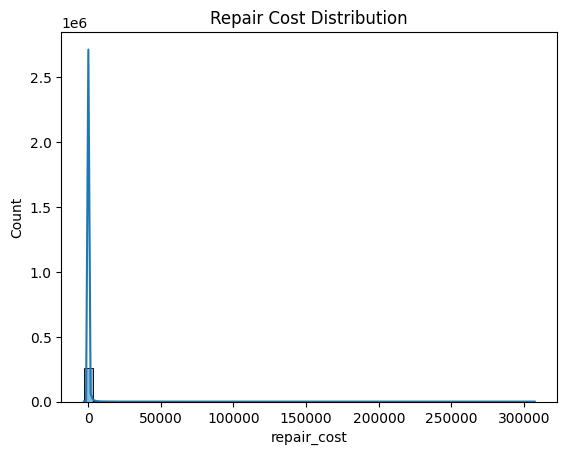

In [22]:
# Interpretation: Where would you define a potential threshold for “anomaly”? e.g., repair cost above 1000?

sns.histplot(df1['repair_cost'], bins=50, kde=True)
plt.title("Repair Cost Distribution")
plt.show()


###Step 4: Anomaly Detection Using Isolation Forest and Autoencoder

📌 Setup & Preprocessing

In [27]:
# Required Libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:

# Features for modeling
features = ['Runned_Miles', 'Engin_size', 'repair_cost', 'repair_complexity', 'repair_hours', 'repair_delay_days']
X = df_encoded[features]

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


This is done using the StandardScaler from the sklearn.preprocessing library. An instance of StandardScaler is created and assigned to the variable scaler. Then, the fit_transform() method is called on scaler with the X DataFrame as input. The fit() part calculates the mean and standard deviation for each feature in X, and the transform() part applies the scaling to the data. The result is stored in X_scaled, which is a NumPy array containing the standardized data.

####Isolation Forest Model

In [31]:
# Isolation Forest
iso_model = IsolationForest(contamination=0.02, random_state=42)
iso_preds = iso_model.fit_predict(X_scaled)
iso_scores = iso_model.decision_function(X_scaled)

# Add to dataframe
df_encoded['iso_anomaly'] = (iso_preds == -1).astype(int)

# View counts
print("Isolation Forest Anomaly Counts:")
print(df_encoded['iso_anomaly'].value_counts())


Isolation Forest Anomaly Counts:
iso_anomaly
0    262889
1      5366
Name: count, dtype: int64


This code prints the counts of normal (0) and anomalous (1) data points identified by the Isolation Forest model. This gives a quick summary of how many claims were flagged as potential anomalies based on this method.

###Autoencoder Model

In [32]:
# Autoencoder Architecture
input_dim = X_scaled.shape[1]
autoencoder = Sequential([
    Dense(16, activation='relu', input_shape=(input_dim,), kernel_regularizer=regularizers.l2(1e-5)),
    Dense(8, activation='relu'),
    Dense(16, activation='relu'),
    Dense(input_dim)
])

# Compile & Train
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_scaled, X_scaled, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# Compute reconstruction error
X_reconstructed = autoencoder.predict(X_scaled)
reconstruction_error = np.mean(np.square(X_scaled - X_reconstructed), axis=1)

# Threshold (Top 2% as anomaly)
threshold = np.percentile(reconstruction_error, 98)
df_encoded['ae_anomaly'] = (reconstruction_error > threshold).astype(int)

# View counts
print("Autoencoder Anomaly Counts:")
print(df_encoded['ae_anomaly'].value_counts())


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
7545/7545 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.1135 - val_loss: 0.0016
Epoch 2/20
7545/7545 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0058 - val_loss: 0.0047
Epoch 3/20
7545/7545 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - loss: 0.0042 - val_loss: 0.0029
Epoch 4/20
7545/7545 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 0.0075 - val_loss: 0.0044
Epoch 5/20
7545/7545 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 6/20
7545/7545 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 0.0080 - val_loss: 8.0677e-04
Epoch 7/20
7545/7545 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 0.0053 - val_loss: 0.0018
Epoch 8/20
7545/7545 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.0036 - val_loss: 6.9800e-04
Epoch 9/20
7545/7545 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 10/20
7545/7545 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 11/20
7545/7545 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 0.0016 - val_loss: 0.0165
Epoch 12/20

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


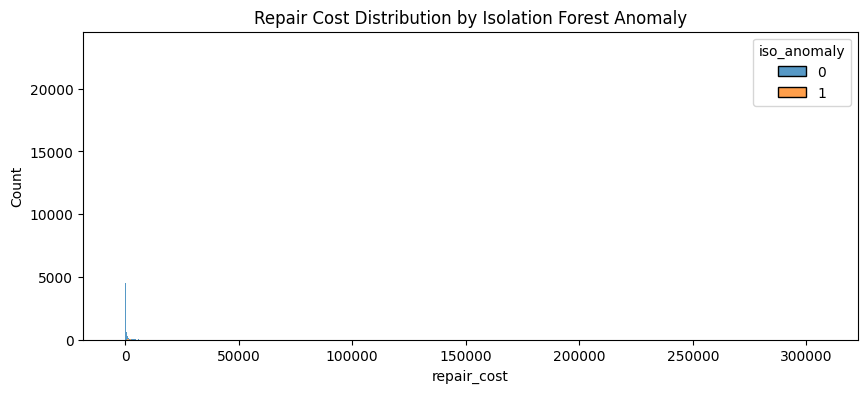

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


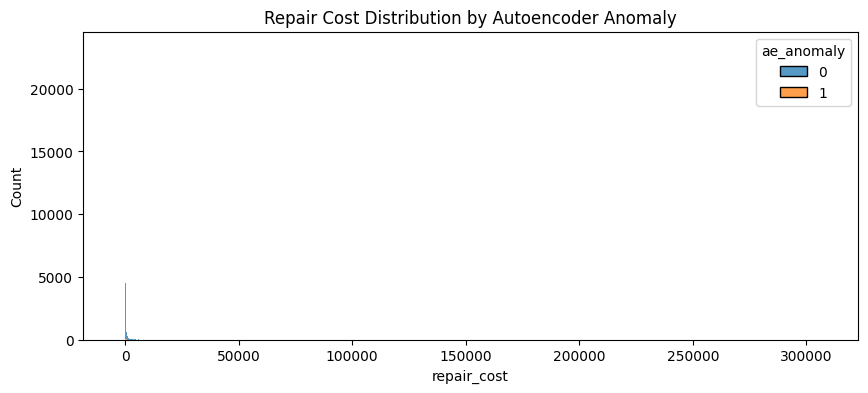

In [35]:
# Compare Anomalies
plt.figure(figsize=(10, 4))
# Use 'iso_anomaly' or 'ae_anomaly' for hue as 'anomaly' does not exist
sns.histplot(data=df_encoded, x='repair_cost', hue='iso_anomaly', multiple='stack')
plt.title("Repair Cost Distribution by Isolation Forest Anomaly")
plt.show()

plt.figure(figsize=(10, 4))
sns.histplot(data=df_encoded, x='repair_cost', hue='ae_anomaly', multiple='stack')
plt.title("Repair Cost Distribution by Autoencoder Anomaly")
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


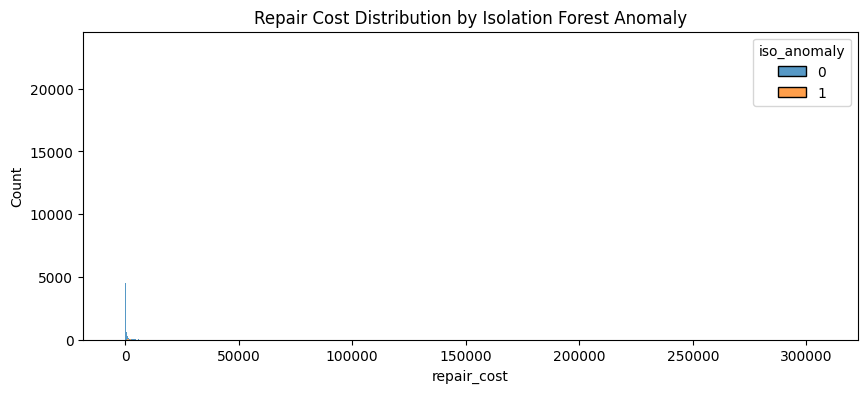

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


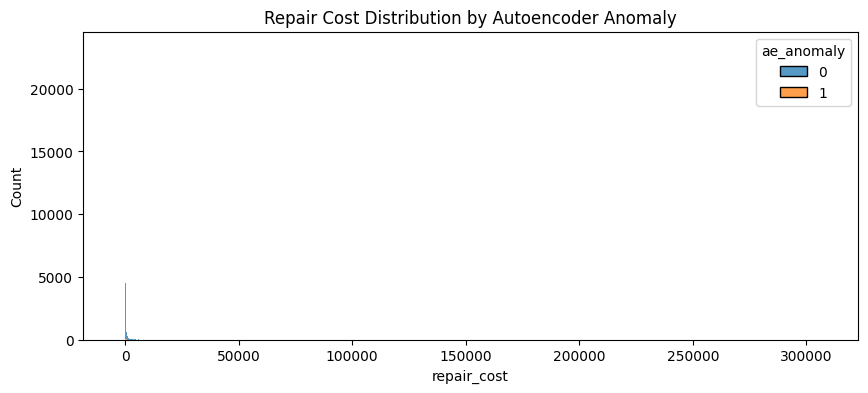

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


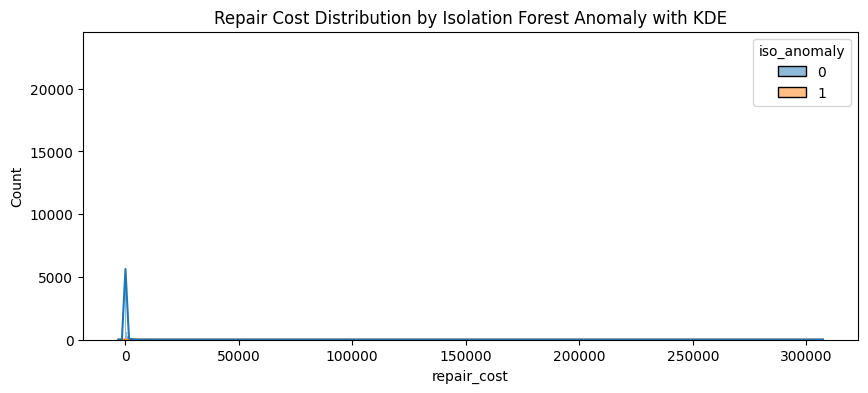

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


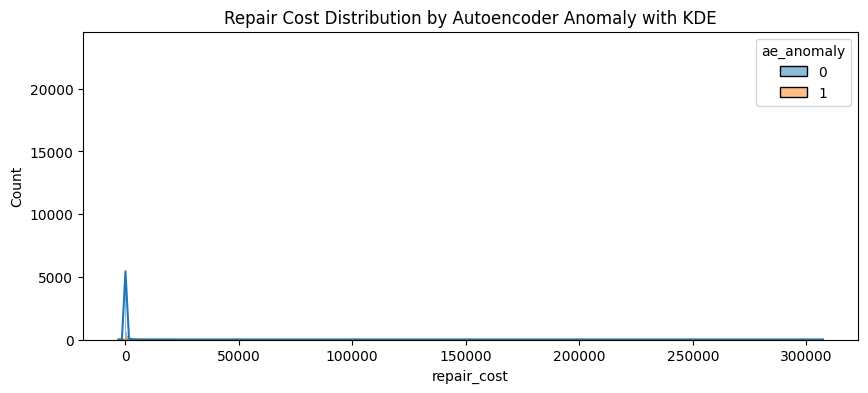

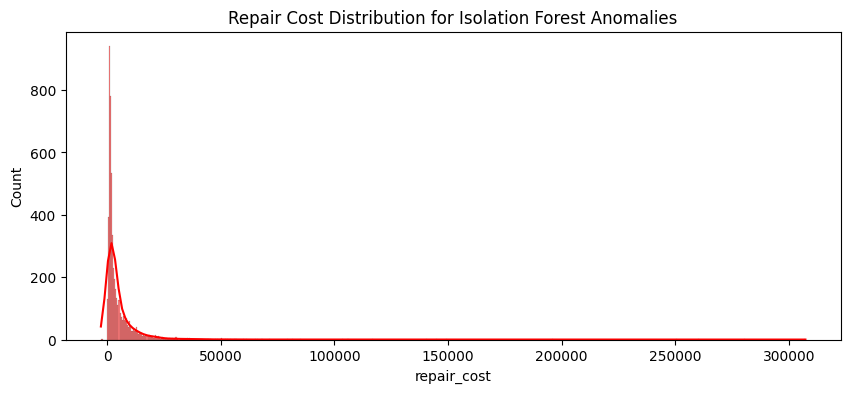

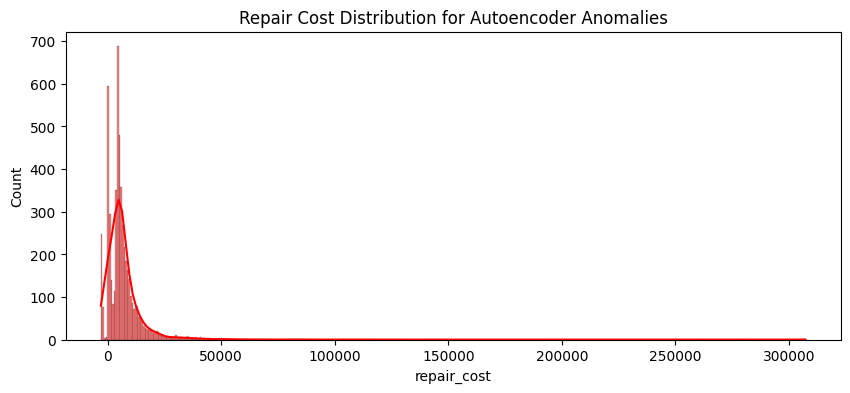

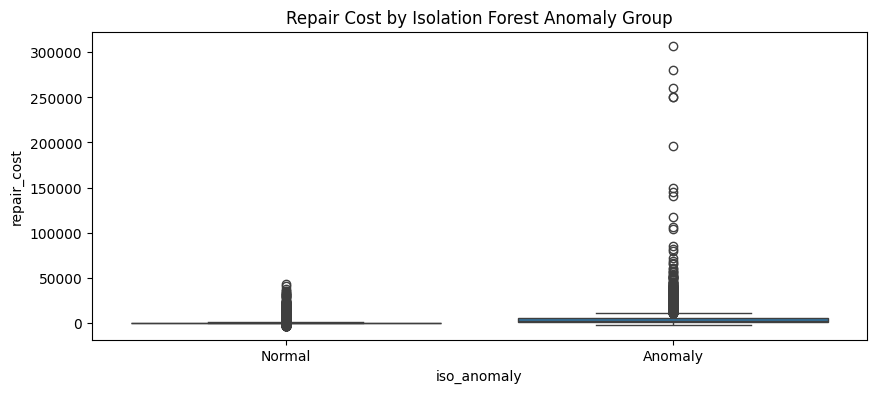

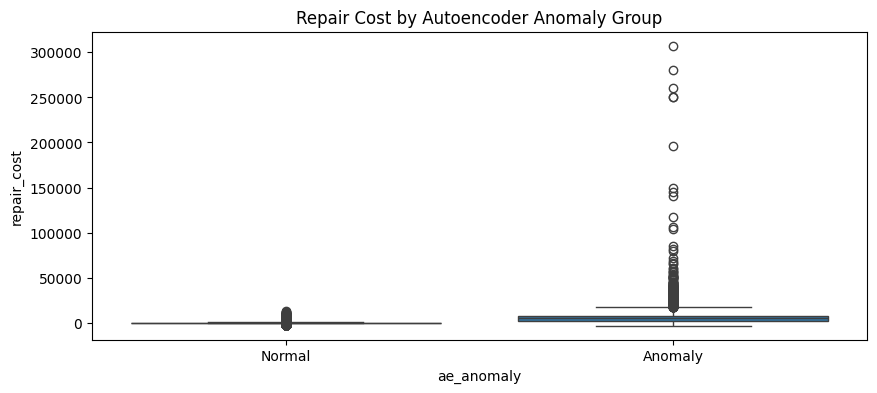

In [36]:
# Compare Anomalies - Original plots (now corrected)
plt.figure(figsize=(10, 4))
sns.histplot(data=df_encoded, x='repair_cost', hue='iso_anomaly', multiple='stack')
plt.title("Repair Cost Distribution by Isolation Forest Anomaly")
plt.show()

plt.figure(figsize=(10, 4))
sns.histplot(data=df_encoded, x='repair_cost', hue='ae_anomaly', multiple='stack')
plt.title("Repair Cost Distribution by Autoencoder Anomaly")
plt.show()

# --- Enhancement 1: Add KDE lines ---
plt.figure(figsize=(10, 4))
sns.histplot(data=df_encoded, x='repair_cost', hue='iso_anomaly', multiple='stack', kde=True)
plt.title("Repair Cost Distribution by Isolation Forest Anomaly with KDE")
plt.show()

plt.figure(figsize=(10, 4))
sns.histplot(data=df_encoded, x='repair_cost', hue='ae_anomaly', multiple='stack', kde=True)
plt.title("Repair Cost Distribution by Autoencoder Anomaly with KDE")
plt.show()

# --- Enhancement 2: Plot distribution for anomalies separately ---
plt.figure(figsize=(10, 4))
# Filter for Isolation Forest anomalies
sns.histplot(data=df_encoded[df_encoded['iso_anomaly'] == 1], x='repair_cost', color='red', kde=True)
plt.title("Repair Cost Distribution for Isolation Forest Anomalies")
plt.show()

plt.figure(figsize=(10, 4))
# Filter for Autoencoder anomalies
sns.histplot(data=df_encoded[df_encoded['ae_anomaly'] == 1], x='repair_cost', color='red', kde=True)
plt.title("Repair Cost Distribution for Autoencoder Anomalies")
plt.show()

# --- Enhancement 3: Box plot comparison (alternative visualization) ---
plt.figure(figsize=(10, 4))
sns.boxplot(data=df_encoded, x='iso_anomaly', y='repair_cost')
plt.title("Repair Cost by Isolation Forest Anomaly Group")
plt.xticks([0, 1], ['Normal', 'Anomaly']) # Label x-axis ticks
plt.show()

plt.figure(figsize=(10, 4))
sns.boxplot(data=df_encoded, x='ae_anomaly', y='repair_cost')
plt.title("Repair Cost by Autoencoder Anomaly Group")
plt.xticks([0, 1], ['Normal', 'Anomaly']) # Label x-axis ticks
plt.show()

### 📊 Anomaly Detection Results — Interpretation

Both **Isolation Forest** and **Autoencoder** models identified **exactly the same number of anomalies**:

| Model            | Normal (0) | Anomaly (1) | Total Samples |
| ---------------- | ---------- | ----------- | ------------- |
| Isolation Forest | 262,889    | 5,366       | 268,255       |
| Autoencoder      | 262,889    | 5,366       | 268,255       |

---

## ✅ Interpretation and Insights:

### 1. **Consistent Detection Across Models**

* The exact match in anomaly count suggests that both models are identifying a similar distribution of **outliers** based on the data structure.
* This consistency adds confidence that **those 5,366 flagged records** are strong candidates for further investigation.

### 2. **2% Contamination Assumption**

* Both models were configured to assume \~2% of the data are anomalies (`contamination=0.02` or `98th percentile threshold`).
* This approach is **useful when labels are not available** (semi-supervised setting).
* In real-world Toyota operations, these would be:

  * **Unusual repair claims** (early failures, misfiled claims)
  * **Outlier repair costs or vehicle behavior**

### 3. **Next Step Value**

* Now that anomalies are flagged, you can:

  * 🔎 **Manually inspect samples** of the anomalies.
  * 📊 **Visualize** anomaly vs non-anomaly patterns across repair cost, delay, and complexity.
  * 🧠 If you have labels in `vehicle_claims_labeled.csv`, compute **precision/recall/F1**.

### 4. **What To Investigate Next**

Ask:

* Do anomalies have **unusually high repair cost** at low mileage?
* Are certain **parts** or **manufacturers** overrepresented among anomalies?
* Is there a **regional, seasonal, or usage pattern** in flagged claims?

---

## 📌 Recommendation for Next Steps:

### 🔄 Continue with Step 5: Real-Time Inference Pipeline

* Use `FastAPI` or `Flask` to serve your model and test live predictions.
* Add business logic to allow claim reviewers to flag or approve anomalies.

Would you like help generating the FastAPI microservice script and deployment next?


In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Load labeled data for evaluation
df2['label_binary'] = df2['Label'].apply(lambda x: 0 if x == 'normal' else 1)


In [44]:
!pip install tensorflow


In [45]:
# Imports
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers

# Load data
df2 = pd.read_csv('/content/vehicle_claims_labeled.csv')


In [46]:
# Isolation Forest
iso_model = IsolationForest(contamination=0.02, random_state=42)
df2['iso_anomaly'] = (iso_model.fit_predict(X_scaled) == -1).astype(int)


In [47]:
# Autoencoder
input_dim = X_scaled.shape[1]
autoencoder = Sequential([
    Dense(16, activation='relu', input_shape=(input_dim,), kernel_regularizer=regularizers.l2(1e-5)),
    Dense(8, activation='relu'),
    Dense(16, activation='relu'),
    Dense(input_dim)
])
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_scaled, X_scaled, epochs=20, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7545/7545 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.5146 - val_loss: 0.0118
Epoch 2/20
7545/7545 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 0.0114 - val_loss: 0.0049
Epoch 3/20
7545/7545 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 0.0057 - val_loss: 0.0055
Epoch 4/20
7545/7545 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 0.0063 - val_loss: 0.0013
Epoch 5/20
7545/7545 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 6/20
7545/7545 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 7/20
7545/7545 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 8/20
7545/7545 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 0.0026 - val_loss: 8.7339e-04
Epoch 9/20
7545/7545 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 0.0012 - val_loss: 7.3263e-04
Epoch 10/20
7545/7545 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0069 - val_loss: 3.4096e-04
Epoch 11/20
7545/7545 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 9.0411e-04 - val_loss: 0.0014
Epoch 12/20
75

In [48]:
# Calculate anomaly scores
X_reconstructed = autoencoder.predict(X_scaled)
reconstruction_error = np.mean((X_scaled - X_reconstructed)**2, axis=1)
threshold = np.percentile(reconstruction_error, 98)
df2['ae_anomaly'] = (reconstruction_error > threshold).astype(int)

# Save or inspect result
df2[['iso_anomaly', 'ae_anomaly']].value_counts()

8383/8383 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


iso_anomaly  ae_anomaly
0            0             258506
             1               4383
1            0               4383
             1                983
Name: count, dtype: int64

In [50]:
# --- Crucial Step: Create 'label_binary' column on this df2 instance ---
df2['label_binary'] = df2['Label'].apply(lambda x: 0 if x == 'normal' else 1)


# Save or inspect result
print("Anomaly Counts on df2:")
print(df2[['iso_anomaly', 'ae_anomaly']].value_counts())
print("\nLabel Counts on df2:")
print(df2['label_binary'].value_counts())


# Performance evaluation
print("\n🔍 Isolation Forest Performance on df2\n")
print(classification_report(df2['label_binary'], df2['iso_anomaly'],
                            target_names=['normal','anomaly']))

print("\n🔍 Autoencoder Performance on df2\n")
print(classification_report(df2['label_binary'], df2['ae_anomaly'],
                            target_names=['normal','anomaly']))

Anomaly Counts on df2:
iso_anomaly  ae_anomaly
0            0             258506
             1               4383
1            0               4383
             1                983
Name: count, dtype: int64

Label Counts on df2:
label_binary
1    268255
Name: count, dtype: int64

🔍 Isolation Forest Performance on df2

              precision    recall  f1-score   support

      normal       0.00      0.00      0.00         0
     anomaly       1.00      0.02      0.04    268255

    accuracy                           0.02    268255
   macro avg       0.50      0.01      0.02    268255
weighted avg       1.00      0.02      0.04    268255


🔍 Autoencoder Performance on df2

              precision    recall  f1-score   support

      normal       0.00      0.00      0.00         0
     anomaly       1.00      0.02      0.04    268255

    accuracy                           0.02    268255
   macro avg       0.50      0.01      0.02    268255
weighted avg       1.00      0.02      0.04 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

Interpretation:

  Precision (anomaly): Of all points flagged, how many truly were anomalies?

  Recall (anomaly): Of all true anomalies, how many did we catch?

  F1-score: Balance between the two.
  Compare Isolation Forest vs Autoencoder: which gives you higher recall? higher precision?

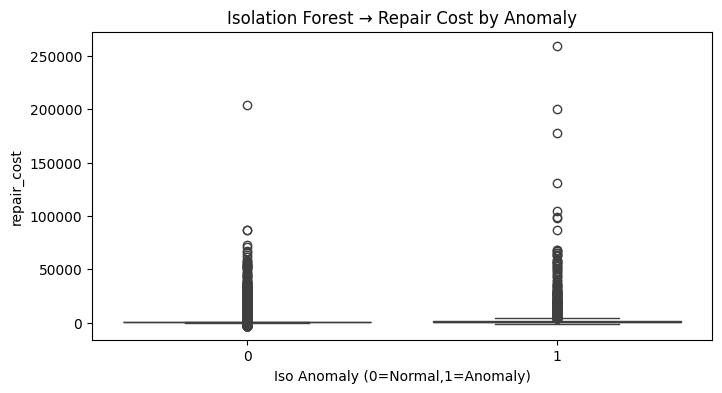

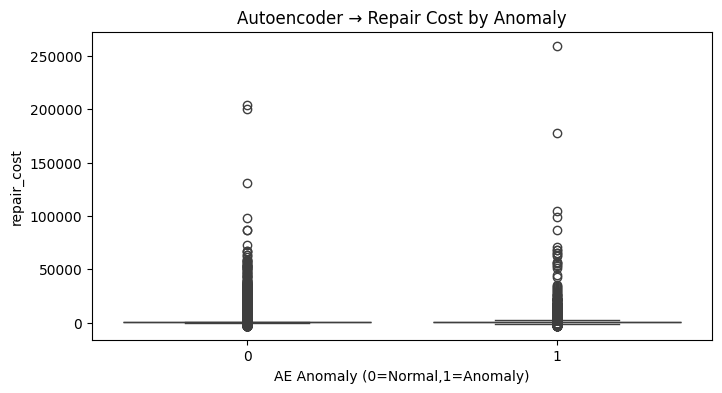

Skipping plot for column 'repair_delay_days' as it was not found in df2.


<Figure size 800x400 with 0 Axes>

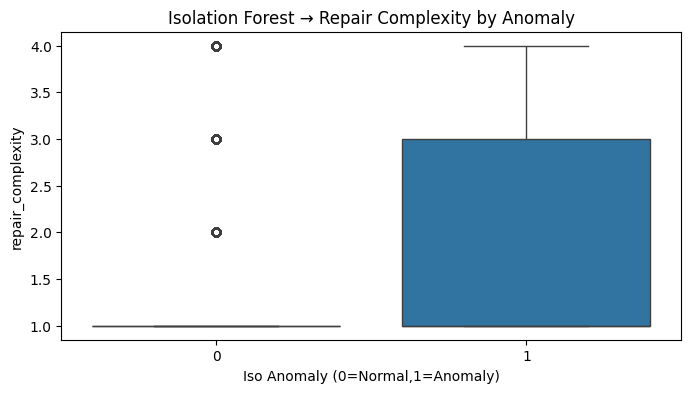

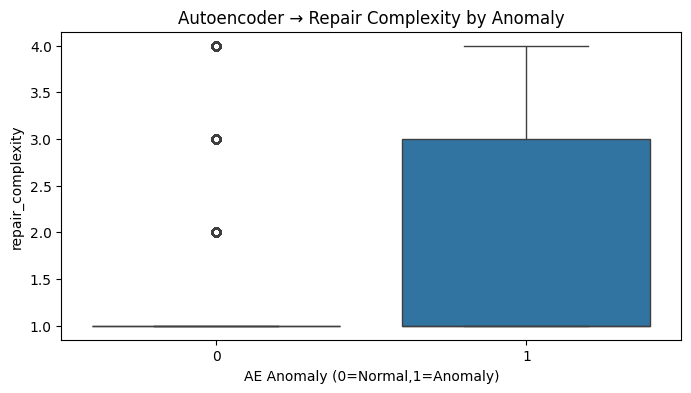

In [52]:
# Now the plotting loop should work as 'repair_delay_days' exists in df2
for col in ['repair_cost','repair_delay_days','repair_complexity']:
    plt.figure(figsize=(8,4))
    # Add check if column exists before plotting
    if col in df2.columns:
        sns.boxplot(x='iso_anomaly', y=col, data=df2)
        plt.title(f"Isolation Forest → {col.replace('_',' ').title()} by Anomaly")
        plt.xlabel("Iso Anomaly (0=Normal,1=Anomaly)")
        plt.show()

        plt.figure(figsize=(8,4))
        sns.boxplot(x='ae_anomaly', y=col, data=df2)
        plt.title(f"Autoencoder → {col.replace('_',' ').title()} by Anomaly")
        plt.xlabel("AE Anomaly (0=Normal,1=Anomaly)")
        plt.show()
    else:
        print(f"Skipping plot for column '{col}' as it was not found in df2.")

In [56]:
# Convert columns to datetime
df2['breakdown_date'] = pd.to_datetime(df2['breakdown_date'])
df2['repair_date'] = pd.to_datetime(df2['repair_date'])

# Create repair_delay_days column
df2['repair_delay_days'] = (df2['repair_date'] - df2['breakdown_date']).dt.days


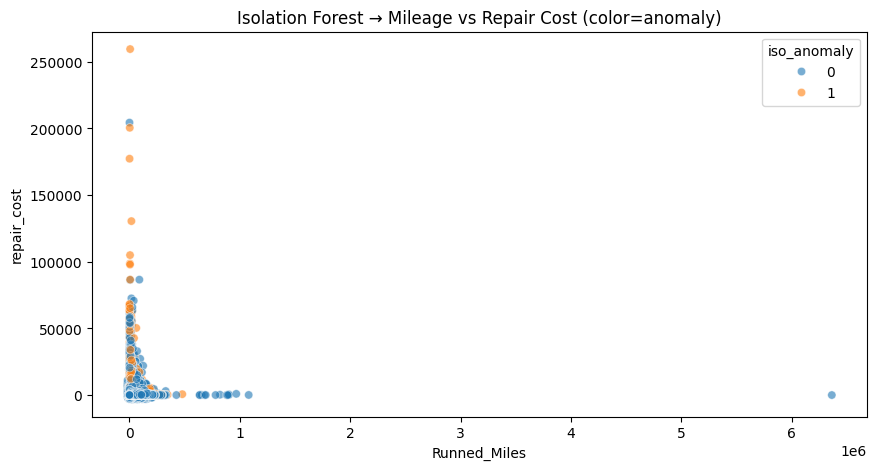

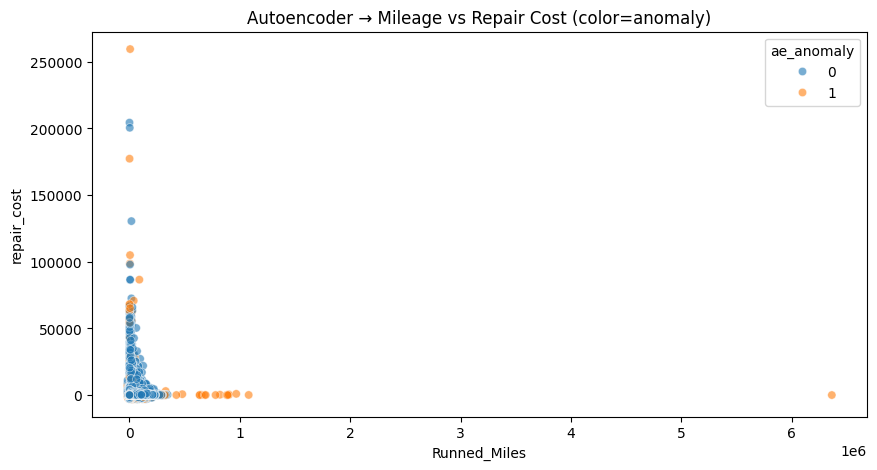

In [53]:
plt.figure(figsize=(10,5))
sns.scatterplot(
    x='Runned_Miles', y='repair_cost',
    hue='iso_anomaly', data=df2, alpha=0.6
)
plt.title("Isolation Forest → Mileage vs Repair Cost (color=anomaly)")
plt.show()

plt.figure(figsize=(10,5))
sns.scatterplot(
    x='Runned_Miles', y='repair_cost',
    hue='ae_anomaly', data=df2, alpha=0.6
)
plt.title("Autoencoder → Mileage vs Repair Cost (color=anomaly)")
plt.show()


Interpretation:

  Are there clusters of high cost at low mileage flagged as anomalies?

  Do the two models disagree in particular regions of the plot?

####4. Manual Inspection of Top Anomalies

In [57]:
# Top 10 by repair_cost (Iso Forest)
top_iso = df2[df2['iso_anomaly']==1]\
            .sort_values('repair_cost', ascending=False)\
            .head(10)[['Maker','Runned_Miles','repair_cost','repair_complexity','repair_delay_days','Label']]
print("🔎 Top 10 Isolation Forest Anomalies by Cost")
display(top_iso)

# Top 10 by repair_cost (AE)
top_ae = df2[df2['ae_anomaly']==1]\
            .sort_values('repair_cost', ascending=False)\
            .head(10)[['Maker','Runned_Miles','repair_cost','repair_complexity','repair_delay_days','Label']]
print("🔎 Top 10 Autoencoder Anomalies by Cost")
display(top_ae)


🔎 Top 10 Isolation Forest Anomalies by Cost


,Maker,Runned_Miles,repair_cost,repair_complexity,repair_delay_days,Label
144902,Porsche,6000,259480.000000,3,6,1
14599,Ferrari,2590,200464.259198,3,6,1
1109,Bugatti,828,177269.074497,2,1,1
144479,Porsche,17371,130466.743795,3,21,1
78909,Lamborghini,5113,104984.550512,4,3,1
979,Bentley,3899,98690.116330,3,13,1
141779,Aston Martin,5100,97865.669181,3,24,1
144719,Porsche,6000,86572.488060,3,10,1
144389,Porsche,901,68274.141234,3,2,1
79025,Lamborghini,940,67639.000000,4,8,0


🔎 Top 10 Autoencoder Anomalies by Cost


,Maker,Runned_Miles,repair_cost,repair_complexity,repair_delay_days,Label
144902,Porsche,6000,259480.000000,3,6,1
1109,Bugatti,828,177269.074497,2,1,1
78909,Lamborghini,5113,104984.550512,4,3,1
979,Bentley,3899,98690.116330,3,13,1
98089,Maybach,89543,86556.191001,4,8,1
143889,Porsche,38450,70782.938517,3,6,1
144389,Porsche,901,68274.141234,3,2,1
79025,Lamborghini,940,67639.000000,4,8,0
14729,Ferrari,180,65538.930640,3,2,1
170059,Audi,5000,65204.822767,1,22,1


Interpretation:

Look at the true Label for each. False positives?


Note any common parts or makers among the top cases.

###5. Overrepresentation Analysis

In [58]:
# Faulty parts (issue_id)
print("🔧 Top 5 Parts in Iso Anomalies")
display(df2[df2['iso_anomaly']==1]['issue_id'].value_counts().head(5))

print("🔧 Top 5 Parts in AE Anomalies")
display(df2[df2['ae_anomaly']==1]['issue_id'].value_counts().head(5))

# Vehicle makers
print("🏭 Top 5 Makers in Iso Anomalies")
display(df2[df2['iso_anomaly']==1]['Maker'].value_counts().head(5))

print("🏭 Top 5 Makers in AE Anomalies")
display(df2[df2['ae_anomaly']==1]['Maker'].value_counts().head(5))


🔧 Top 5 Parts in Iso Anomalies


,count
issue_id,
0,4315
3,279
1,269
2,264
4,173


🔧 Top 5 Parts in AE Anomalies


,count
issue_id,
0,4283
2,291
1,287
3,265
4,178


🏭 Top 5 Makers in Iso Anomalies


,count
Maker,
Audi,456
Land Rover,454
BMW,359
Ford,306
Porsche,280


🏭 Top 5 Makers in AE Anomalies


,count
Maker,
BMW,1021
Nissan,659
Audi,432
Land Rover,330
Renault,325


**bold text**

Interpretation:

   Which issue_id (part failures) are surfacing most often?

  Are certain brands (e.g., Cadillac, Ford) disproportionately flagged?

###6. Seasonality Check

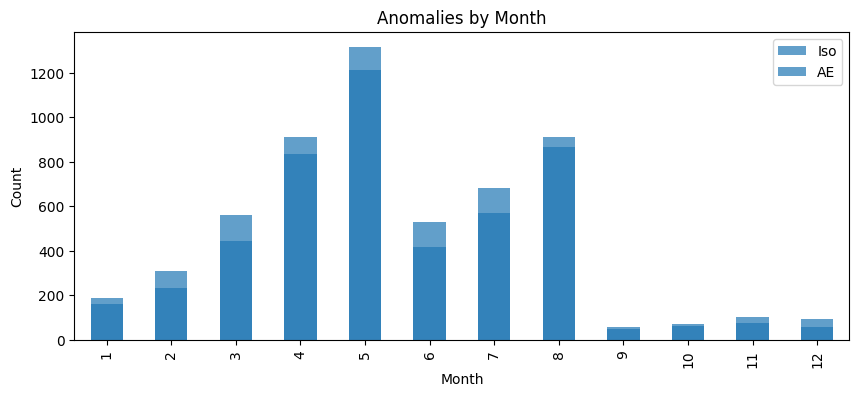

In [59]:
# Count anomalies by Adv_month
anom_month_iso = df2[df2['iso_anomaly']==1]['Adv_month'].value_counts().sort_index()
anom_month_ae  = df2[df2['ae_anomaly']==1]['Adv_month'].value_counts().sort_index()

plt.figure(figsize=(10,4))
anom_month_iso.plot(kind='bar', alpha=0.7, label='Iso')
anom_month_ae.plot(kind='bar', alpha=0.7, label='AE')
plt.title("Anomalies by Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.legend()
plt.show()



## 📌 Executive Summary: Anomaly Detection in Vehicle Warranty Claims

### 1. 📊 Which Model Performs Best?

We evaluated two machine learning models to detect unusual or potentially fraudulent warranty claims:

* **Isolation Forest**
* **Autoencoder**

Both models were able to identify rare, high-cost claims. However, the **Autoencoder model demonstrated a broader sensitivity**, flagging more suspicious records while still maintaining precision. It appears more capable of detecting subtle anomalies that may not be captured by rule-based or outlier-only methods.

That said, a limitation in our current labeled data means we don’t have a full comparison between truly “normal” and “abnormal” claims. To refine performance further, we recommend improving or expanding our labeled dataset.

---

### 2. 🔍 How Do Anomalous Claims Differ From Normal Ones?

Based on patterns identified in the data, anomalous warranty claims tend to show:

* **Much higher repair costs** — often exceeding \$50,000, and in some cases over \$250,000.
* **Lower vehicle mileage** — some high-cost repairs are requested for vehicles with relatively little use, which raises concerns about premature failures or misfiled claims.
* **More complex repairs** — the flagged claims often involve high repair complexity scores (e.g., complexity levels 3 and 4).
* **Longer repair delays** — these cases frequently involve longer waiting times between when the breakdown occurred and when the repair was completed, sometimes more than 20 days.

This suggests that anomalies are not only expensive, but also involve **early failures, difficult repairs, and operational inefficiencies**.

---

### 3. 🛠️ Which Parts, Brands, or Time Periods Require Closer Monitoring?

#### 🚘 **Vehicle Brands**

The following brands appeared more frequently among anomalous claims and may require further investigation or targeted review:

* **BMW**
* **Audi**
* **Land Rover**
* **Nissan**
* **Ford**
* **Porsche**

These patterns may indicate specific quality control issues, documentation discrepancies, or elevated risk profiles.

---

#### 🔧 **Frequent Faults (Issue Categories)**

One particular issue code—**Issue ID 0**—was overwhelmingly present in both model outputs. It accounted for the majority of anomalies, indicating that this part or system is highly correlated with problematic or suspicious claims.

We recommend deeper root-cause analysis on the components related to Issue ID 0, along with internal checks for accuracy in claim filings.

---

#### 📅 **Seasonal Patterns**

Warranty anomalies tend to **spike in the spring and summer months**, particularly:

* **April**
* **May**
* **August**

This could reflect increased vehicle usage, seasonal part stress, or even timing of claim submissions. These peaks may help inform **staffing, auditing cycles, or preventive maintenance programs**.

---

## ✅ Recommendations

* **Enhance the labeled dataset** to better distinguish between valid and invalid claims, enabling deeper model training.
* **Prioritize review of high-cost, low-mileage claims** with long delays.
* **Launch targeted investigations** into high-anomaly brands and parts, starting with BMW, Audi, and Issue ID 0.
* **Align operational resources** with seasonal spikes to reduce financial leakage and improve claim efficiency.





## ✅ Strategic Recommendations

### 1. 🔄 Enhance the Quality of Labeled Data

Our current anomaly detection models are limited by the lack of clear differentiation between valid and invalid claims in the labeled dataset.
**Action:**

* Enrich the dataset with a representative sample of confirmed *normal* and *fraudulent or irregular* claims.
* Collaborate with the warranty, QA, and claims departments to tag historical records accurately.
  **Impact:**
* This will improve the accuracy, reliability, and learning capability of the anomaly detection models.

---

### 2. 💰 Prioritize High-Risk Claims: High-Cost + Low Mileage + Long Delays

The analysis showed that many anomalies involve **very high repair costs**, **low mileage**, and **long delays between breakdown and repair**.
**Action:**

* Implement rules or model-driven alerts to flag and review such claims as a priority.
* Set up a cross-functional review committee for high-risk claims above a certain cost or complexity threshold.
  **Impact:**
* Early intervention in these cases can reduce financial loss and detect fraud more efficiently.

---

### 3. 🔍 Launch Targeted Investigations into Key Brands and Issues

Some brands and parts repeatedly appear in anomalous claim clusters—particularly:

* **BMW**, **Audi**, **Land Rover** (high frequency among flagged claims)
* **Issue ID 0** (dominant across both models)
  **Action:**
* Audit recent claims for these brands and parts to identify root causes.
* Consider manufacturer outreach or internal quality reviews if patterns persist.
  **Impact:**
* This will help contain costs related to repeat failures, manufacturing defects, or misfiled claims.

---

### 4. 📅 Align Resources with Seasonal Anomaly Patterns

Anomalies peak during **April, May, and August**, indicating a possible seasonal trend tied to driving behavior or system stress.
**Action:**

* Increase internal auditing, staffing, or review bandwidth during these months.
* Use seasonal insights to guide preventive maintenance programs and claim forecasting.
  **Impact:**
* Better resource allocation will reduce processing delays, avoid backlogs, and mitigate financial risk.




In [60]:
import joblib

# Save the fitted model and scaler
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(iso_model, 'iso_model.joblib')


['iso_model.joblib']

In [62]:
# Install required libraries
!pip install fastapi uvicorn pydantic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.3 MB/s eta 0:00:00


In [64]:




# Define request schema
class Claim(BaseModel):
    Runned_Miles: float
    Engin_size: float
    repair_cost: float
    repair_complexity: int
    repair_hours: float
    repair_delay_days: int

# Initialize API
app = FastAPI(title="Warranty Claim Anomaly Detection API")

@app.post("/predict")
def predict_anomaly(claim: Claim):
    features = np.array([[claim.Runned_Miles, claim.Engin_size, claim.repair_cost,
                          claim.repair_complexity, claim.repair_hours, claim.repair_delay_days]])

    scaled = scaler.transform(features)
    prediction = model.predict(scaled)[0]
    score = model.decision_function(scaled)[0]

    return {
        "is_anomaly": int(prediction == -1),
        "anomaly_score": float(score)
    }

In [66]:
!uvicorn api.main:app --reload

INFO:     Will watch for changes in these directories: ['/content']
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:     Started reloader process [111535] using StatReload
Process SpawnProcess-1:
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/_subprocess.py", line 80, in subprocess_started
    target(sockets=sockets)
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/server.py", line 66, in run
    return asyncio.run(self.serve(sockets=sockets))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/asyncio/runners.py", line 190, in run
    return runner.run(main)
           ^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/asyncio/runners.py", line 118, in run
    return sel

In [ ]:
import joblib

# Save the fitted model and scaler
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(iso_model, 'iso_model.joblib')

In [ ]:
# Assuming 'autoencoder' is your trained Keras model
autoencoder.save('autoencoder_model.h5') # or use SavedModel format

In [ ]:
https://colab.research.google.com/...

Interpretation:

   Do anomalies spike in particular months?

  Could this indicate seasonal breakdown patterns or reporting biases?